# Lecture 31: Regression Inference

In [1]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
%matplotlib inline
np.set_printoptions(legacy='1.13')

## Linear regression

In [2]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers)) / np.std(any_numbers)  

def correlation(t, x, y):
    """Return the correlation coefficient (r) of two variables."""
    return np.mean(standard_units(t.column(x)) * standard_units(t.column(y)))

def slope(t, x, y):
    """The slope of ther regression line (original units)."""
    r = correlation(t, x, y)
    return r * np.std(t.column(y)) / np.std(t.column(x))

def intercept(t, x, y):
    """The intercept of the regression line (original units)."""
    return np.mean(t.column(y)) - slope(t, x, y) * np.mean(t.column(x))

def fit(table, x, y):
    """Return the height of the regression line at each x value."""
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

def predict(table, x, y, new_x):
    """Return the prediction for new_x using linear regression."""
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * new_x + b    

def plot_residuals(t, x, y):
    """Plot a scatter diagram and residuals."""
    t.scatter(x, y, fit_line=True)
    actual = t.column(y)
    fitted = fit(t, x, y)
    residuals = actual - fitted
    print('r:   ', correlation(t, x, y))
    print('RMSE:', np.mean(residuals**2)**0.5)
    t.select(x).with_column('Residual', residuals).scatter(0, 1)

## Prediction from a sample, not a population

r:    0.320949896064
RMSE: 3.3880799164


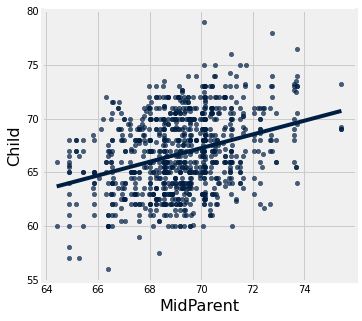

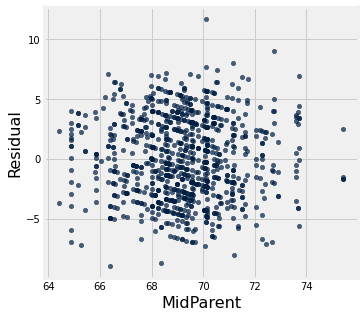

In [3]:
# We've been treating this table as a population.  It's not really.
galton = Table.read_table('galton.csv')

heights = Table().with_columns(
    'MidParent', galton.column('midparentHeight'),
    'Child', galton.column('childHeight')
)

heights_pred = heights.with_column(
    'Predicted', fit(heights, 'MidParent', 'Child')
)

plot_residuals(heights_pred, 'MidParent', 'Child')

r:    0.258360027879
RMSE: 3.38425120227
Prediction for MidParent=70 is Child= 67.1868957062


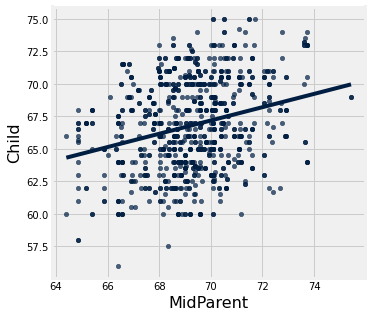

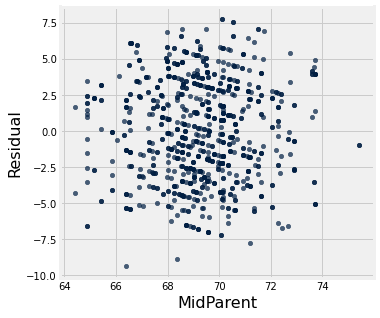

In [7]:
# How differently could the prediction have come out?
sample_heights = heights.sample()
sample_heights_pred = sample_heights.with_column(
    'Predicted', fit(sample_heights, 'MidParent', 'Child')
)

plot_residuals(sample_heights_pred, 'MidParent', 'Child')
print('Prediction for MidParent=70 is Child=', predict(sample_heights_pred, 'MidParent', 'Child', 70))

## Bootstrap CI for prediction

Approximate 95%-confidence interval of regression height:
( 67.0201330884 , 67.4917158756 )


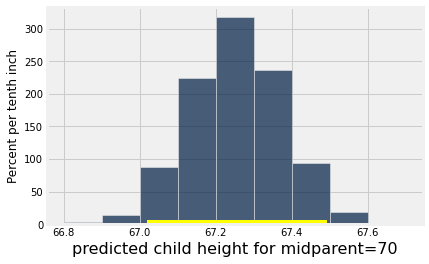

In [8]:
# Bootstrap the predicted height at midparent = 70
predicted_heights = make_array()

for i in np.arange(5000):
    sample_heights = heights.sample()
    pred_height = predict(sample_heights, 'MidParent', 'Child', 70)
    predicted_heights = np.append(predicted_heights, pred_height)

# Compute CI    
left = percentile(2.5, predicted_heights)
right = percentile(97.5, predicted_heights)

# Visualize
Table().with_column('Prediction', predicted_heights).hist(bins=np.arange(66.8, 67.8, 0.1), unit='tenth inch')
plots.xlabel('predicted child height for midparent=70')
plots.plot([left, right], [0, 0], color='yellow', lw=8);
print('Approximate 95%-confidence interval of regression height:')
print('(', left, ',', right, ')')

## Prediction intervals

As of Monday, someone was at 286 gestational days, and will max out at 293.  Can we predict the birth weight for each day, as a 95% CI?

In [9]:
baby = Table.read_table('baby.csv')
baby.show(3)

r:    0.407542793389
RMSE: 16.7303582567


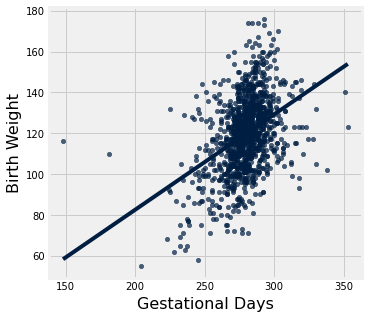

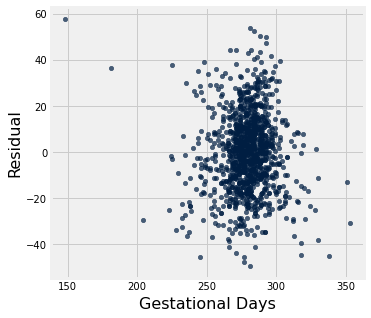

In [10]:
# Does linear regression look appropriate?
plot_residuals(baby, 'Gestational Days', 'Birth Weight')

**Note:** RMSE is about 1 lb!  So our predictions could still be off by a sizable amount.

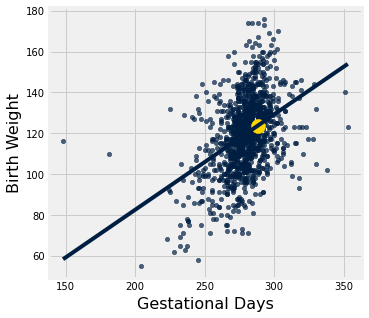

In [11]:
# A prediction for x=288
x = 288
a = slope(baby, 'Gestational Days', 'Birth Weight')
b = intercept(baby, 'Gestational Days', 'Birth Weight')
predicted_y = a * x + b
baby.scatter('Gestational Days', 'Birth Weight', fit_line=True)
plots.scatter(x, predicted_y, color='gold', s=200);

In [12]:
predicted_y

123.61424164692373

In [13]:
print(int(predicted_y // 16), 'lbs,', int(round(predicted_y % 16,0)), 'oz')

7 lbs, 12 oz


r: 0.422900325654


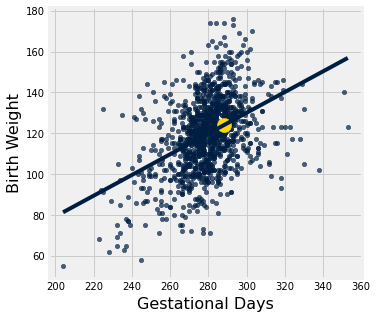

In [14]:
# Could those outliers have a big effect?
x = 288

baby_wo_outliers = baby.where('Gestational Days', are.above(200))
a = slope(baby_wo_outliers, 'Gestational Days', 'Birth Weight')
b = intercept(baby_wo_outliers, 'Gestational Days', 'Birth Weight')
r = correlation(baby_wo_outliers, 'Gestational Days', 'Birth Weight')
predicted_y = a * x + b
baby_wo_outliers.scatter('Gestational Days', 'Birth Weight', fit_line=True)
plots.scatter(x, predicted_y, color='gold', s=200);
print('r:', r)

r: 0.40784618563
r: 0.407336092946
r: 0.387415344251
r: 0.449094458559


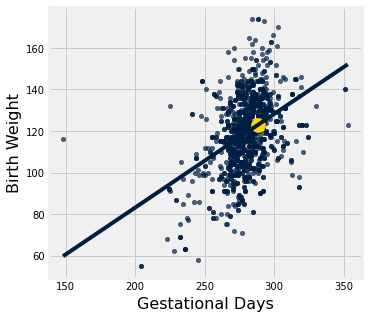

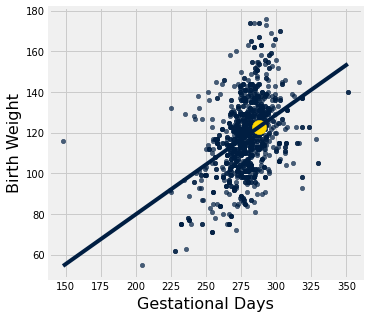

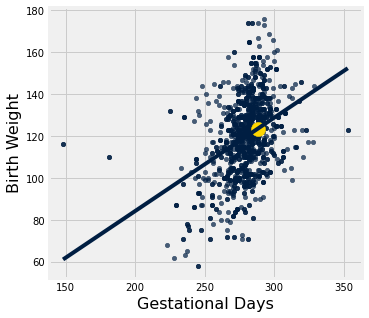

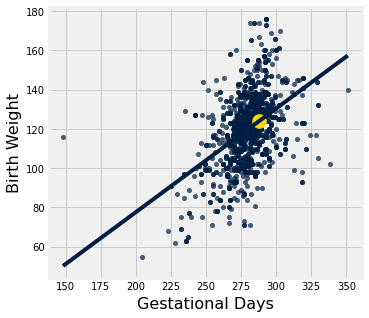

In [15]:
for i in np.arange(4):
    baby_resample = baby.sample()
    a = slope(baby_resample, 'Gestational Days', 'Birth Weight')
    b = intercept(baby_resample, 'Gestational Days', 'Birth Weight')
    r = correlation(baby_resample, 'Gestational Days', 'Birth Weight')
    predicted_y = a * x + b
    baby_resample.scatter('Gestational Days', 'Birth Weight', fit_line=True)
    plots.scatter(x, predicted_y, color='gold', s=200);
    print('r:', r)

Outliers do have an effect on line and prediction, but absent a good reason (e.g., known errors) we can't exclude them just to get a better fitting line.  

In [16]:
def bootstrap_prediction(table, x, y, new_xs):
    """Bootstrap a 95% CI for a prediction of each new_x in
    the array new_xs.  Return a table with all the CIs."""

    lefts = make_array()
    rights = make_array()
    
    for new_x in new_xs:
        # Bootstrap resampling
        predictions = make_array()
        for i in np.arange(5000):
            resample = table.sample()
            a = slope(resample, x, y)
            b = intercept(resample, x, y)
            predicted_y = a * new_x + b
            predictions = np.append(predictions, predicted_y)

        # 95% CI
        left = percentile(2.5, predictions)
        right = percentile(97.5, predictions)
        lefts = np.append(lefts, left)
        rights = np.append(rights, right)
        
    intervals = Table().with_columns(
        'new x', new_xs,
        'left', lefts,
        'right', rights
    )
    
    return intervals

In [17]:
bootstrap_prediction(baby, 'Gestational Days', 'Birth Weight', 
                     make_array(288))

new x | left    | right
288   | 122.449 | 124.88

In [18]:
bootstrap_prediction(baby, 'Gestational Days', 'Birth Weight', 
                     np.arange(286, 286+8))

new x | left    | right
286   | 121.573 | 123.825
287   | 122.026 | 124.286
288   | 122.449 | 124.785
289   | 122.873 | 125.376
290   | 123.219 | 125.908
291   | 123.702 | 126.386
292   | 124.026 | 127.037
293   | 124.494 | 127.509

In [ ]:
# We could report CIs with and without outliers, though, and let
# reader draw their own conclusion
bootstrap_prediction(baby.where('Gestational Days', are.above(200)), 
                     'Gestational Days', 'Birth Weight', np.arange(286, 286+8))

**Q:** Is there a 95% chance that the birth weight of a baby born at 288 gestational days is about 122-125?

A. Yes  
B. No  

<br/><br/><br/><br/><br/>

## A Hypothesis Test

r:    0.0269829110029
RMSE: 18.3141929836


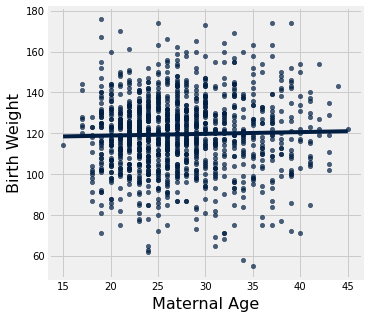

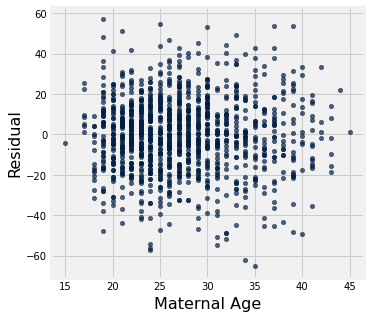

In [19]:
plot_residuals(baby, 'Maternal Age', 'Birth Weight')

**Q:** Should we attempt to use maternal age to predict birth weight?

A. Yes  
B. No  

<br/><br/><br/><br/><br/>

**Null Hypothesis:** The correlation of Maternal Age to Birth Weight is 0.   
**Alternative Hypothesis:** Not 0.    



In [20]:
num_repetitions = 5000

def bootstrap_ci_correlation(table, x, y):
    """95% confidence interval for the correlation of x and y."""
    correlations = make_array()
    for i in np.arange(num_repetitions):
        resample = table.sample()
        resample_r = correlation(resample, x, y)
        correlations = np.append(correlations, resample_r)

    left = percentile(2.5, correlations)
    right = percentile(97.5, correlations)

    Table().with_column('Correlation', correlations).hist()
    plots.plot([left,right], [0,0], color='yellow', lw=8);

    print("95% confidence interval is (", left, ", ", right, ")")

95% confidence interval is ( -0.0336103300082 ,  0.0881819959558 )


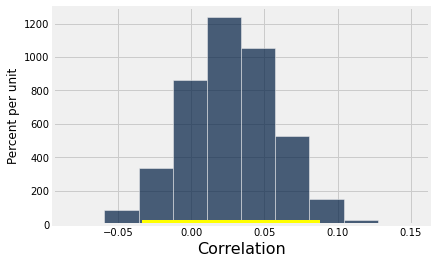

In [21]:
bootstrap_ci_correlation(baby, 'Maternal Age', 'Birth Weight')

95% CI contains 0.0, so we cannot reject the null hypothesis at a p-value of 0.05.